# Lab 4. Word embeddings.

Для начала, как всегда, всевозможные приготовления к работе. Использовать будем заранее предобработанные текты из трёх википедий — английской, русской и simple. Большая часть лабы выполнялась на full, но переключение на любую другую производится заменой единственного параметра (не то чтобы это было неочевидно, впрочем).

In [1]:
import collections
import math
import os
import random
from datetime import datetime
from itertools import accumulate
import itertools
from IPython.display import clear_output
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import tensorflow as tf
import pickle
import stop_words
import regex as re
import sys

import scipy
from scipy import sparse

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
import sklearn.decomposition
from sklearn.manifold import TSNE

In [2]:
class Wiki:
    def __init__(self, wiki):
        self.wiki = wiki
        self.__set_params()

        if not os.path.exists(self.folder):
            os.mkdir(self.folder)

        self.counter, self.vocab, self.rev_vocab = self.__get_vocab()


    def __set_params(self):
        WIKIS = {
            'full': {
                'lang': 'en',
                'wiki_file': '/Users/akiiino/Documents/Wiki/full/processed.dat',
                'vocab_size': 150000,
                'folder': 'full'
            },
            'simple': {
                'lang': 'en',
                'wiki_file': '/Users/akiiino/Documents/Wiki/simple/processed.dat',
                'vocab_size': 50000,
                'folder': 'simple'
            },
            'ru': {
                'lang': 'ru',
                'wiki_file': '/Users/akiiino/Documents/Wiki/ru/processed.dat',
                'vocab_size': 100000,
                'folder': 'ru'
            },
        }


        self.lang = WIKIS[self.wiki]['lang']
        self.__wiki_file = WIKIS[self.wiki]['wiki_file']
        self.vocab_size = WIKIS[self.wiki]['vocab_size']
        self.folder = WIKIS[self.wiki]['folder']
        
        self.word_count_file = os.path.join(self.folder, 'word_counts')
        self.lsa_tf_idf_file = os.path.join(self.folder, 'LSA_TfIdf.npz')
        self.lsa_embeds_file = os.path.join(self.folder, 'LSA_embed.npy')
        self.w2v_embeds_file = os.path.join(self.folder, 'W2V_embed.npy')
        self.glove_cooccur_matrix_file = os.path.join(self.folder, 'glove_coocc.npz')
        self.glove_embeds_file = os.path.join(self.folder, 'glove_embed.npy')

        self.__stop_words = set(stop_words.get_stop_words(self.lang))
        self.__punct_finder = re.compile(r"\p{P}+")


    def _normalize(self, text):
        text = text.lower()
        text = self.__punct_finder.sub("", text)
        text = (word for word in text.split() if word not in self.__stop_words)
        return text


    def wiki_gen(self, use_vocab=True, chunk_size=2**26, single_pass=False, joined=False):
        total_read = 0
        last_reported = 0

        with open(self.__wiki_file) as wiki_file:
            while True:
                lines = " ".join(wiki_file.readlines(chunk_size))
                total_read += len(lines)

                if total_read - last_reported >= 2**20:
                    last_reported = total_read
                    print('Pulling... total {} MB'.format(total_read//2**20), end="\r")

                if not lines:
                    if single_pass:
                        return
                    wiki_file.seek(0)
                    print("\nStarting over...")
                    continue

                lines = self._normalize(lines)

                if use_vocab:
                    lines = (self.vocab[word] if word in self.vocab else 0 for word in lines)

                if not joined:
                    yield lines
                else:
                    yield " ".join(lines)


    def __get_vocab(self):
        if not os.path.exists(self.word_count_file):
            counter = collections.Counter()

            for chunk in self.wiki_gen(use_vocab=False, single_pass=True):
                counter.update(chunk)

            with open(self.word_count_file, 'wb') as file:
                pickle.dump(counter, file)

        else:
            with open(self.word_count_file, 'rb') as file:
                counter = collections.Counter(pickle.load(file))


        unk_count = sum(counter.values()) - sum(x[1] for x in counter.most_common(self.vocab_size - 1))
        counter = dict([('UNK', unk_count)] + counter.most_common(self.vocab_size - 1))

        vocab     = {word: num for num, (word, _) in enumerate(counter.items())}
        rev_vocab = list(vocab.keys())

        return counter, vocab, rev_vocab

In [3]:
wiki = Wiki("simple")

## LSA

### **Задание**
**1**.  Вычислите $X$ понравившимся способом (возможно, стоит использовать разреженную матрицу).

**2**. Обучите представления слов при $k = 128$ на своем корпусе.

Обучение устроено просто: пайплайн из `sklearn`'ового `TfidfVectorizer` для построения самой матрицы $X$, после чего Truncated SVD в виде `scipy.sparse.linalg.svds`.

In [4]:
def build_lsa(wiki):
    vectorizer = TfidfVectorizer(vocabulary=wiki.vocab)
    tf_idf_matrix = vectorizer.fit_transform(
        wiki.wiki_gen(
            chunk_size=1,
            use_vocab=False,
            single_pass=True,
            joined=True
        )
    ).T
    np.savez(wiki.lsa_tf_idf_file, tf_idf_matrix)

    print("Tf-Idf done")

    svd = sklearn.decomposition.TruncatedSVD(n_components=128)

    lsa_embeds = svd.fit_transform(tf_idf_matrix)
    print("SVD done")

    return lsa_embeds

In [5]:
def get_lsa(wiki):
    if not os.path.exists(wiki.lsa_embeds_file):
        lsa_embeds = build_lsa(wiki)
        np.save(wiki.lsa_embeds_file, lsa_embeds)
    else:
        lsa_embeds = np.load(wiki.lsa_embeds_file)

    return lsa_embeds

In [6]:
lsa_embeds = get_lsa(wiki)

При этом после вычисления всё сохраняется на диск, чтобы лишний раз не считать, если понадобится снова.

**3**. Реализуйте поиск k-ближайших соседей для Евклидовой меры в 128-мерном пространстве .

Скелет для нахождения соседей: по вектору находим ближайшие слова; сложность линейная, т.к. использован `argpartition`. Сам вектор может быть получен как напрямую из слова, так и, например, сложениями и вычитаниями других векторов.

In [7]:
def get_closest_to_vec(vec, embeds, wiki, metric_name='euclid', count=10, with_dists=False):
        metrics = {
            'euclid': euclidean_distances,
            'cosine': cosine_similarity,
            'manhattan': manhattan_distances
        }

        metric = metrics[metric_name]

        dists = metric(
                [vec],
                embeds
        )[0]

        if metric_name == "cosine":
                closest_indexes = dists.argpartition(range(-count, 0))[-1:-count-1:-1]
        else:
                closest_indexes = dists.argpartition(range(0, count))[:count]
                
        closest_words = (wiki.rev_vocab[x] for x in closest_indexes if x)
        
        if with_dists:
            closest_words = zip(dists[closest_indexes], closest_words)

        return list(closest_words)

Сам поиск по словам:

In [8]:
def get_closest_words(word, embeds, wiki, metric='euclid', count=10, with_dists=False):
    return get_closest_to_vec(embeds[wiki.vocab[word]], embeds, wiki, metric, count, with_dists)

In [9]:
EXAMPLE_WORDS = ["field", "directed", "financial", "road", "provides", "player", "2011", "edition", "battle", "ended", "son", "least", "mexico", "male", "medal", "big", "central", "according", "km", "year", "rights", "george", "founded", "tournament", "instead", "movie", "445", "system", "york", "win"]

**4**. Найдите 10 ближайших представлений к 30 словам, которые выбрали сами. Попытайтесь сделать так, чтобы примеры были интересными.

In [10]:
for word in EXAMPLE_WORDS:
    print(word.ljust(10), ":", " ".join(get_closest_words(word, lsa_embeds, wiki)[1:]))

field      : physical 400 blind finish individual relay wheelchair cerebral atlanta
directed   : reviews stars comedy drama critics positive rating produced rotten
financial  : offices businesses owns insurance projects employees improve report nonprofit
road       : street yorkshire route market sussex runs devon kent centre
provides   : standards communications projects provide improve customers engineers technologies costs
player     : japanese former brazilian 22 20 21 17 28 23
2011       : 2009 2008 2006 2004 2003 2005 2002 1998 announced
edition    : articles 2003 encyclopedia article website online users pages wiki
battle     : army forces fought military soldiers ii troops confederate attack
ended      : lasted beginning continued returned decided due led happened powerful
son        : prince wife daughter queen father henry charles duke edward
least      : present whole half rather complete longer recent nearly past
mexico     : mexican pacific cuba storms winds landfall puert

Есть несколько интересных вещей.
Например, следующее:
- То, как сгруппированы числа (а особенно то, что рядом находятся числа схожей величины);
- то, что рядом со словом "york" находятся также и "jersey", и "new", с которого обычно начинаются оба;
- то, как "central" явно встречается преимущественно в географическом контексте;
- Википедия явно очень беспокоится о правах в Латвии;
- среди мужских имён почему-то затесалось "wife".

**5**. Проделайте то же самое для косинусной меры. Какой результат вам показался более интересным?


In [11]:
for word in EXAMPLE_WORDS:
    print(word.ljust(10), ":", " ".join(get_closest_words(word, lsa_embeds, wiki, metric="cosine")[1:]))

field      : physical type thrower improved coils 400 thereby swimming metre
directed   : ebert movie tomatoes rotten biographical sanjay rating grossing theaters
financial  : investments banking business investment employees corporate offices corporations funds
road       : motorway a1 a38 a14 a6 witham hertfordshire northamptonshire penzance
provides   : access provide standards funding telecommunications providers consumer communications employees
player     : 163 126 61 177 227 192 paraguayan 269 112
2011       : 2009 2008 2002 2012 2006 2003 announced 2004 2005
edition    : wikipedia articles wikipedias nupedia essjay encyclopedia bomis wikimedia wikiversity
battle     : fought battles commanded cavalry armies decisive retreated reinforcements casualties
ended      : lasted regained rival began 10th remained took beginning failed
son        : cousin eldest wife nephew brother daughter grandson sons halfbrother
least      : indicated present whole apart fairly however half yet incr

Тут вообще непонятно что происходит. Видимо, в длине векторов тоже есть важная информация и лучше было всё же с евклидовой метрикой.

**6**. Предложите свою меру длины, проверьте, как она работает.

In [12]:
for word in EXAMPLE_WORDS:
    print(word.ljust(10), ":", " ".join(get_closest_words(word, lsa_embeds, wiki, metric="manhattan")[1:]))

field      : physical blind wheelchair cerebral relay 400 palsy move individual
directed   : reviews stars rating positive rotten critics produced tomatoes drama
financial  : insurance employees investment corporate offices owns prices marketing fund
road       : street yorkshire route side market greater centre sussex kent
provides   : standards communications provide projects installed customers provided technologies engineers
player     : players 28 tennis retired 36 japanese 35 chess 33
2011       : 2009 2008 2006 2005 2003 2004 2002 1998 announced
edition    : articles encyclopedia 2003 article website pages wiki wikipedias newspaper
battle     : army forces fought military soldiers ii troops killed confederate
ended      : lasted continued returned beginning wars ottoman victory invasion remained
son        : prince queen wife father duke daughter charles henry princess
least      : present whole recent rather complete actually likely half unlike
mexico     : mexican el cuba juan

В целом, примерно как и в евклидовой метрике.

## Word2Vec

Сначала о теории:

### **Задание**

**1**. Как можно представить модель skip-gram в виде нейронной сети?

Тут практически нет отличий от CBOW. Два линейных слоя без нелинейности между ними, в конце --- softmax. На вход сеть принимает one-hot вектор размерности $W$, кодирующий центральное слово; на выходе --- вектор той же размерности, представляющий собой вероятности каждого слова.

**2**. Оцените сложность обучения skip-gram модели относительно параметров
* $T$ - размер корпуса;
* $W$ - размер словаря;
* $c$ - радиус окна;
* $d$ - размерность представлений;

** Forward propagation:**

$(d \times W) \cdot (W \times 1); (W \times d) \cdot (d \times 1) \implies O(WD) + O(WD) = O(WD)$;

Softmax --- ещё дополнительно линейное (от $W$) время. Итого $O(WD)$ --- ничего страшного.

** Backpropagation:**

Взятие производных функции ошибки --- $O(Wdc)$, т.к. мы берём производные по матрицам размера $O(Wd)$, и наш размер контекста --- $c$. При этом нам надо это будет сделать $O(T)$ раз --- для каждого батча.

Итого --- $O(TWdc)$

Батчи генерируются из скользящего окна шириной `context_width`; из каждого окна берётся `context_examples` пар слов.

In [13]:
def w2v_batch_gen(batch_size, context_examples, context_width):
    assert batch_size % context_examples == 0
    assert context_examples <= 2 * context_width

    gen = wiki.wiki_gen()

    pulled = 0
    buffer = collections.deque()

    while True:
        while len(buffer) < 2 * context_width + batch_size // context_examples:
            buffer.extend(next(gen))

        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

        span = 2 * context_width + 1

        for i in range(batch_size // context_examples):
            target = context_width
            available_targets = list(range(span))
            available_targets.remove(target)
            chosen_targets = random.sample(available_targets, context_examples)

            for j, target in enumerate(chosen_targets):
                batch[i * context_examples + j] = buffer[context_width]
                labels[i * context_examples + j, 0] = buffer[target]
            buffer.popleft()
        yield batch, labels

### **Задание**
1. Выберите понравивщуюся вам функцию потерь. Оцените сложность обучения для нее, сравните с простым softmax.
2. На основе оценки сложности определиться с количеством эпох, размера вектора $d$ = 256 будет достаточно. Определитесь с размером окна. Будьте готовы, что на большом корпусе обучение может длиться около суток.

Пользоваться будем NCE --- преимущественно из-за простоты реализации. Сложность обучения оценить легко: фактически, единственное существенное изменение (асимптотики, разумеется; сами алгоритмы отличаются существенно) заключается в том, что вместо прохода по всем $W$ словам, мы рассматриваем только $k$ cлучайных слов; итого сложность $O(Tcdk)$.

In [14]:
W2V_PARAMS = {
    'batch_size': 256,
    'embedding_dim': 256,
    'context_width': 6,
    'context_examples': 4,
    'neg_samples': 100
}

In [15]:
w2v_graph = tf.Graph()
with w2v_graph.as_default():
    train_inputs = tf.placeholder(tf.int32, shape=[W2V_PARAMS['batch_size']])
    train_labels = tf.placeholder(tf.int32, shape=[W2V_PARAMS['batch_size'], 1])

    all_embeddings = tf.Variable(
        tf.random_uniform(
            [wiki.vocab_size, W2V_PARAMS['embedding_dim']],
            -1.0,
            1.0
        )
    )
    embed = tf.nn.embedding_lookup(all_embeddings, train_inputs)

    weights = tf.Variable(
        tf.truncated_normal(
            [wiki.vocab_size, W2V_PARAMS['embedding_dim']],
            stddev=1.0 / math.sqrt(W2V_PARAMS['embedding_dim'])
        )
    )
    biases = tf.Variable(tf.zeros([wiki.vocab_size]))

    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=weights,
            biases=biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=W2V_PARAMS['neg_samples'],
            num_classes=wiki.vocab_size
        )
    )

    optimizer = tf.train.AdagradOptimizer(0.5).minimize(loss)

    init = tf.global_variables_initializer()

Экспериментальным путём выяснено, что десяти миллионов итераций достаточно, чтобы обучиться (по крайней мере до состояния, где заметных улучшений нет). Занимает это (у меня, по крайней мере) около восьми-девяти часов (надо бы, конечно, сделать две-три полные эпохи, но это очень уж долго. Может быть, потом). Девять часов --- это всё-таки немало, так что тут тоже есть возможность загружать и выгружать результаты.

**3**. Обучите skip-gram модель.

In [16]:
def build_w2v(wiki, num_steps=500):
    with tf.Session(graph=w2v_graph) as session:
        init.run()

        average_loss = 0
        batch_gen = w2v_batch_gen(W2V_PARAMS['batch_size'], W2V_PARAMS['context_examples'], W2V_PARAMS['context_width'])
        for step in range(num_steps):
            try:
                for _ in range(10000):
                    batch_inputs, batch_labels = next(batch_gen)
                    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

                    _, loss_val= session.run([optimizer, loss], feed_dict=feed_dict)

                    average_loss += loss_val


                clear_output()
                print("Time: {}; steps: {}; avg. loss: {}.".format(datetime.now().strftime("%H:%M:%S"), step*10000, average_loss/10000))
                average_loss = 0
                w2v_embeds = all_embeddings.eval()
                for i in range(10):
                    word = wiki.rev_vocab[random.randint(1, 150)]
                    print(word.ljust(10), ":", " ".join(get_closest_words(word, w2v_embeds, wiki)[1:]))

            except KeyboardInterrupt:
                break
        w2v_embeds = all_embeddings.eval()

    return w2v_embeds

In [17]:
def get_w2v(wiki):
    if not os.path.exists(wiki.w2v_embeds_file):
        w2v_embeds = build_w2v(wiki)
        np.save(wiki.w2v_embeds_file, w2v_embeds)
    else:
        w2v_embeds = np.load(wiki.w2v_embeds_file)

    return w2v_embeds

In [18]:
w2v_embeds = get_w2v(wiki)

**4**. Попробуйте снова найти ближайшие представления для тех 30 слов. Улучшился ли результат визуально? Попробуйте разные меры расстояния (евклидова, косинусная).

In [19]:
for word in EXAMPLE_WORDS:
    print(word.ljust(10), ":", " ".join(get_closest_words(word, w2v_embeds, wiki)[1:]))

field      : fields also however well just result another rather
directed   : movie starring drama story starred comedy like movies
financial  : business money result also looking however well although
road       : also now along although well however near work
provides   : provide however well possible example also now support
player     : players playing also play played well however one
2011       : 2009 2010 2008 2007 2012 2006 2013 2005 2014
edition    : 14 however 2003 7 version 26 published 8
battle     : fought battles army fighting fight war forces however
ended      : began started beginning end lasted start continued however stopped
son        : father wife daughter later married husband however sons
least      : one however another nearly two since others possible
mexico     : however mexican also well although instead just now
male       : female also however another males one often females
medal      : honor awarded medals silver received award however olympic
big        

Видно, что качество сильно улучшилось; вместо слов, которые относятся примерно к одной теме теперь рядом находятся слова, значащие примерно одно и то же; вместо всяких "founded" --- "university" и прочее, теперь тут "founded: --- "formed", "established"... "bought"... В общем, теперь смысла гораздо больше (что было ясно ещё из сложений-вычитаний).

**5**. Найдите ближайшие вектора для выражения v(king) - v(man) + v(women). Если модель обучена хорошо, то среди ближайших векторов должно быть представление v(queen).


Функция для сложения-вычитания векторов:

In [20]:
def get_analogy(pos, neg, embeds, wiki, metric='euclid', count=10):
    pos_vec = [embeds[wiki.vocab.get(w, 0)] for w in pos]
    neg_vec = [embeds[wiki.vocab.get(w, 0)] for w in neg]

    return [
        pair for pair in get_closest_to_vec(
            sum(pos_vec) - sum(neg_vec),
            embeds,
            wiki,
            metric_name=metric,
            count=count,
            with_dists=True
        ) if pair[1] not in pos and pair[1] not in neg
    ]

Можно поэкспериментировать и посмотреть, что получится. Базовые примеры:

In [21]:
get_analogy(["king", "woman"], ["man"], w2v_embeds, wiki)

[(6.4579649, 'queen'),
 (6.6873565, 'however'),
 (6.7671967, 'instead'),
 (6.8198328, 'also'),
 (6.9159527, 'wife'),
 (7.0099964, 'called'),
 (7.0710826, 'later')]

**6**. На основе арифметических операций над представлениями предложите алгоритмы, которые
  * Для страны определяют столицу
  * Для компании определяют CEO
  * Для прилагательного определяют превосходную форму
  * Для слова определяют множественное число
  * Для слова находит его антоним

#1. Столицы:

In [22]:
def get_capitals(countries):
    return [
        get_analogy(
            [country,
            "moscow",],
            ["russia",],
            w2v_embeds,
            wiki
        )[:2] for country in countries
    ]

countries = [
    "germany",
    "france",
    "japan",
    "spain",
    "canada",
    "greece",
    "albania",
    "afghanistan",
    "algeria",
    "norway",
    "india"
]
print("\n".join(": ".join((word.ljust(11), ", ".join(pair[1].rjust(10) for pair in closest))) for word, closest in zip(countries, get_capitals(countries))))

germany    :     german,     berlin
france     :      paris,      began
japan      :   japanese,      tokyo
spain      :    spanish,     madrid
canada     :       home,      began
greece     :      greek,     athens
albania    :  following,      later
afghanistan:   pakistan,      began
algeria    :         de,  continued
norway     :   addition,      began
india      :     indian,      later


Как видно, работает, но не всегда идеально. Возможно, стоит делать несколько предсказаний и усреднять, но у меня не получилось выжать из этого достойный результат.

#2. CEO:

In [23]:
def get_CEOs(companies):
    return [
        get_analogy(
            ["zuckerberg", company],
            ["facebook"],
            w2v_embeds,
            wiki
        )[:2] for company in companies
    ]

companies = [
    "apple",
    "sun",
    "oracle"
]
print("\n".join(": ".join((word.ljust(11), ", ".join(pair[1].rjust(10) for pair in closest))) for word, closest in zip(companies, get_CEOs(companies))))

apple      :     turned,       case
sun        :  character,     called
oracle     :  character,     turned


Мда. Идея должна бы срaботать, но нужно нечеловеческое время на обучение и словарь побольше.

#3. Прилагательные:

In [24]:
def get_superlatives(adjectives):
    return [
        get_analogy(
            ["fastest", adjective],
            ["fast"],
            w2v_embeds,
            wiki
        )[:2] for adjective in adjectives
    ]

adjectives = [
    "dark",
    "big",
    "good",
    "sharp",
    "strange",
    "blue",
]
print("\n".join(": ".join((word.ljust(11), ", ".join(pair[1].rjust(10) for pair in closest))) for word, closest in zip(adjectives, get_superlatives(adjectives))))

dark       :        one,    outside
big        :    biggest,        one
good       :        one,  important
sharp      :       thus,        one
strange    :        one,    outside
blue       :     colour,     yellow


О, работает! Почти... Смысл точно местами прослеживается.

#4. Множественное число:

In [25]:
def get_plurals(nouns):
    return [
        get_analogy(
            ["boxes", noun],
            ["box"],
            w2v_embeds,
            wiki
        )[:2] for noun in nouns
    ]

nouns = [
    "queen",
    "moose",
    "box",
    "chair",
    "glass",
]
print("\n".join(": ".join((word.ljust(11), ", ".join(pair[1].rjust(10) for pair in closest))) for word, closest in zip(nouns, get_plurals(nouns))))

queen      :       also,    present
moose      :       also,       corn
box        :       also,       well
chair      :      later,        now
glass      :       also,        now


Не очень что-то.

## GloVe

Построим матрицу:

In [26]:
def build_cooccur(wiki, context_width=5, chunk_size = 50000):
    slices = list(
        range(a, b) for a, b in zip(
            range(0, wiki.vocab_size + chunk_size, chunk_size),
            range(chunk_size, wiki.vocab_size + chunk_size, chunk_size)
        )
    )

    mat = scipy.sparse.lil_matrix((wiki.vocab_size, wiki.vocab_size), dtype=np.float32)

    for x, range_x in enumerate(slices):
        for y, range_y in list(enumerate(slices))[x:]:
            local_mat = np.zeros((chunk_size, chunk_size), dtype=np.float32)
            print("starting chunk {}, {}".format(x, y))

            text_gen = wiki.wiki_gen(single_pass=True)

            buffer = collections.deque()
            pulled = 0

            stop = False
            i = 0
            while True:
                i += 1
                if i % 100000 == 0:
                    print("{}\r".format(i), end="")
                while len(buffer) < context_width + 1:
                    try:
                        next_chunk = next(text_gen)
                    except StopIteration:
                        stop = True
                        break
                    buffer.extend(next_chunk)

                if stop:
                    break

                for j in range(1, context_width+1):
                    row, column = sorted([buffer[0], buffer[j]])
                    if row in range_x and column in range_y:
                        if x == y:
                            local_mat[row - x*chunk_size, column - y*chunk_size] += 1./j
                            local_mat[column - y*chunk_size, row - x*chunk_size] += 1./j
                        else:
                            local_mat[row - x*chunk_size, column - y*chunk_size] += 1./j
                buffer.popleft()

            mat[x*chunk_size:(x+1)*chunk_size, y*chunk_size:(y+1)*chunk_size] = local_mat
            if x!= y:
                mat[y*chunk_size:(y+1)*chunk_size, x*chunk_size:(x+1)*chunk_size] = local_mat.T
    mat = scipy.sparse.lil_matrix(mat)
    return mat

In [27]:
def get_cooccur(wiki):
    if not os.path.exists(wiki.glove_cooccur_matrix_file):
        cooccurrences_matrix = build_cooccur(wiki)
        np.savez(wiki.glove_cooccur_matrix_file, cooccurrences_matrix)

    else:
        cooccurrences_matrix = np.load(wiki.glove_cooccur_matrix_file).items()[0][1].item()

    return cooccurrences_matrix

In [28]:
cooccurrences_matrix = get_cooccur(wiki)

In [29]:
def glove_batch_gen(cooccur_mat, batch_size):
    def single_gen():
        for i, (row, data) in enumerate(zip(cooccur_mat.rows, cooccur_mat.data)):
            for data_idx, j in enumerate(row):
                yield i, j, data[data_idx]

    batches = list(single_gen())

    while True:
        np.random.shuffle(batches)
        for batch in range(0, len(batches), batch_size):
            yield zip(*batches[batch:batch+batch_size])

In [30]:
GLOVE_PARAMS = {
    'cooccurrence_cap': 250,
    'scaling_factor_c': 0.75,
    'batch_size': 512,
    'embedding_dim': 256
}

In [31]:
glove_graph = tf.Graph()

with glove_graph.as_default():
    count_max = tf.constant([GLOVE_PARAMS['cooccurrence_cap']], dtype=tf.float32)
    scaling_factor = tf.constant([GLOVE_PARAMS['scaling_factor_c']], dtype=tf.float32)

    focal_input = tf.placeholder(tf.int32, shape=[GLOVE_PARAMS['batch_size']])
    context_input = tf.placeholder(tf.int32, shape=[GLOVE_PARAMS['batch_size']])
    cooccurrence_count = tf.placeholder(tf.float32, shape=[GLOVE_PARAMS['batch_size']])

    focal_embeddings = tf.Variable(
        tf.random_uniform(
            [wiki.vocab_size, GLOVE_PARAMS['embedding_dim']],
            1.0,
            -1.0
        )
    )
    context_embeddings = tf.Variable(
        tf.random_uniform(
            [wiki.vocab_size, GLOVE_PARAMS['embedding_dim']],
            1.0,
            -1.0
        )
    )

    focal_biases = tf.Variable(tf.random_uniform([wiki.vocab_size], 1.0, -1.0))
    context_biases = tf.Variable(tf.random_uniform([wiki.vocab_size], 1.0, -1.0))

    focal_embedding = tf.nn.embedding_lookup([focal_embeddings], focal_input)
    context_embedding = tf.nn.embedding_lookup([context_embeddings], context_input)
    focal_bias = tf.nn.embedding_lookup([focal_biases], focal_input)
    context_bias = tf.nn.embedding_lookup([context_biases], context_input)

    weighting_factor = tf.minimum(
        1.0,
        tf.pow(
            tf.div(
                cooccurrence_count,
                count_max),
            scaling_factor
        )
    )

    embedding_product = tf.reduce_sum(tf.multiply(focal_embedding, context_embedding), 1)

    log_cooccurrences = tf.log(tf.to_float(cooccurrence_count))

    distance_expr = tf.square(tf.add_n([
        embedding_product,
        focal_bias,
        context_bias,
        tf.negative(log_cooccurrences)]
    ))

    glove_losses = tf.multiply(weighting_factor, distance_expr)
    glove_loss = tf.reduce_sum(glove_losses)
    optimizer = tf.train.AdagradOptimizer(0.5).minimize(glove_loss)

    combined_embeddings = tf.add(focal_embeddings, context_embeddings, name="combined_embeddings")

    init = tf.global_variables_initializer()

In [50]:
def build_glove(wiki, num_steps=1500):
    average_loss = 0

    with tf.Session(graph=glove_graph) as session:
        init.run()
        for step in range(num_steps):
            try:
                batch_gen = glove_batch_gen(cooccurrences_matrix, GLOVE_PARAMS['batch_size'])
                for _ in range(1000):
                    centers, contexts, counts = next(batch_gen)
                    if len(counts) != GLOVE_PARAMS['batch_size']:
                        continue
                    feed_dict = {
                        focal_input: centers,
                        context_input: contexts,
                        cooccurrence_count: counts
                    }
                    _, loss_val = session.run([optimizer, glove_loss], feed_dict=feed_dict)
                    average_loss += loss_val
                clear_output()
                print(
                    "Time: {}; steps: {}; avg. loss: {}.".format(
                        datetime.now().strftime("%H:%M:%S"),
                        step*1000,
                        average_loss/1000)
                )
                average_loss = 0
                glove_embeds = combined_embeddings.eval()
                for i in range(10):
                    w = wiki.rev_vocab[random.randint(1, 150)]
                    print(w.ljust(10), ":", " ".join(get_closest_words(w, glove_embeds, wiki)[1:]))
            except KeyboardInterrupt:
                break
        glove_embeds = combined_embeddings.eval()
    return glove_embeds

In [51]:
def get_glove(wiki):
    if not os.path.exists(wiki.glove_embeds_file):
        glove_embeds = build_glove(wiki)
        np.save(wiki.glove_embeds_file, glove_embeds)
    else:
        glove_embeds = np.load(wiki.glove_embeds_file)
    return glove_embeds

In [ ]:
glove_embeds = get_glove(wiki)

Time: 19:01:21; steps: 499000; avg. loss: 4.305550966978073.
example    : means similar sometimes usually often another way even rather
like       : sometimes often look usually even called similar well also
sometimes  : often usually like called even example although means instead
different  : similar various types ways certain example several many often
river      : flows along valley near joins west across lies mouth
four       : three five two six eight seven several one nine
like       : sometimes often look usually even called similar well also
since      : first however later 2005 although 2002 now started 2009
life       : rest however although thought though even well way whole
game      

Теперь T-SNE. Тут тоже просто библиотечная реализация. Единственное, если вогнать всю матрицу, падает от нехватки памяти, так что обойдёмся первыми 10к векторов.

In [35]:
tsne = TSNE(3)
post_tsne_glove = tsne.fit(glove_embeds[:10000])

<IPython.core.display.Javascript object>


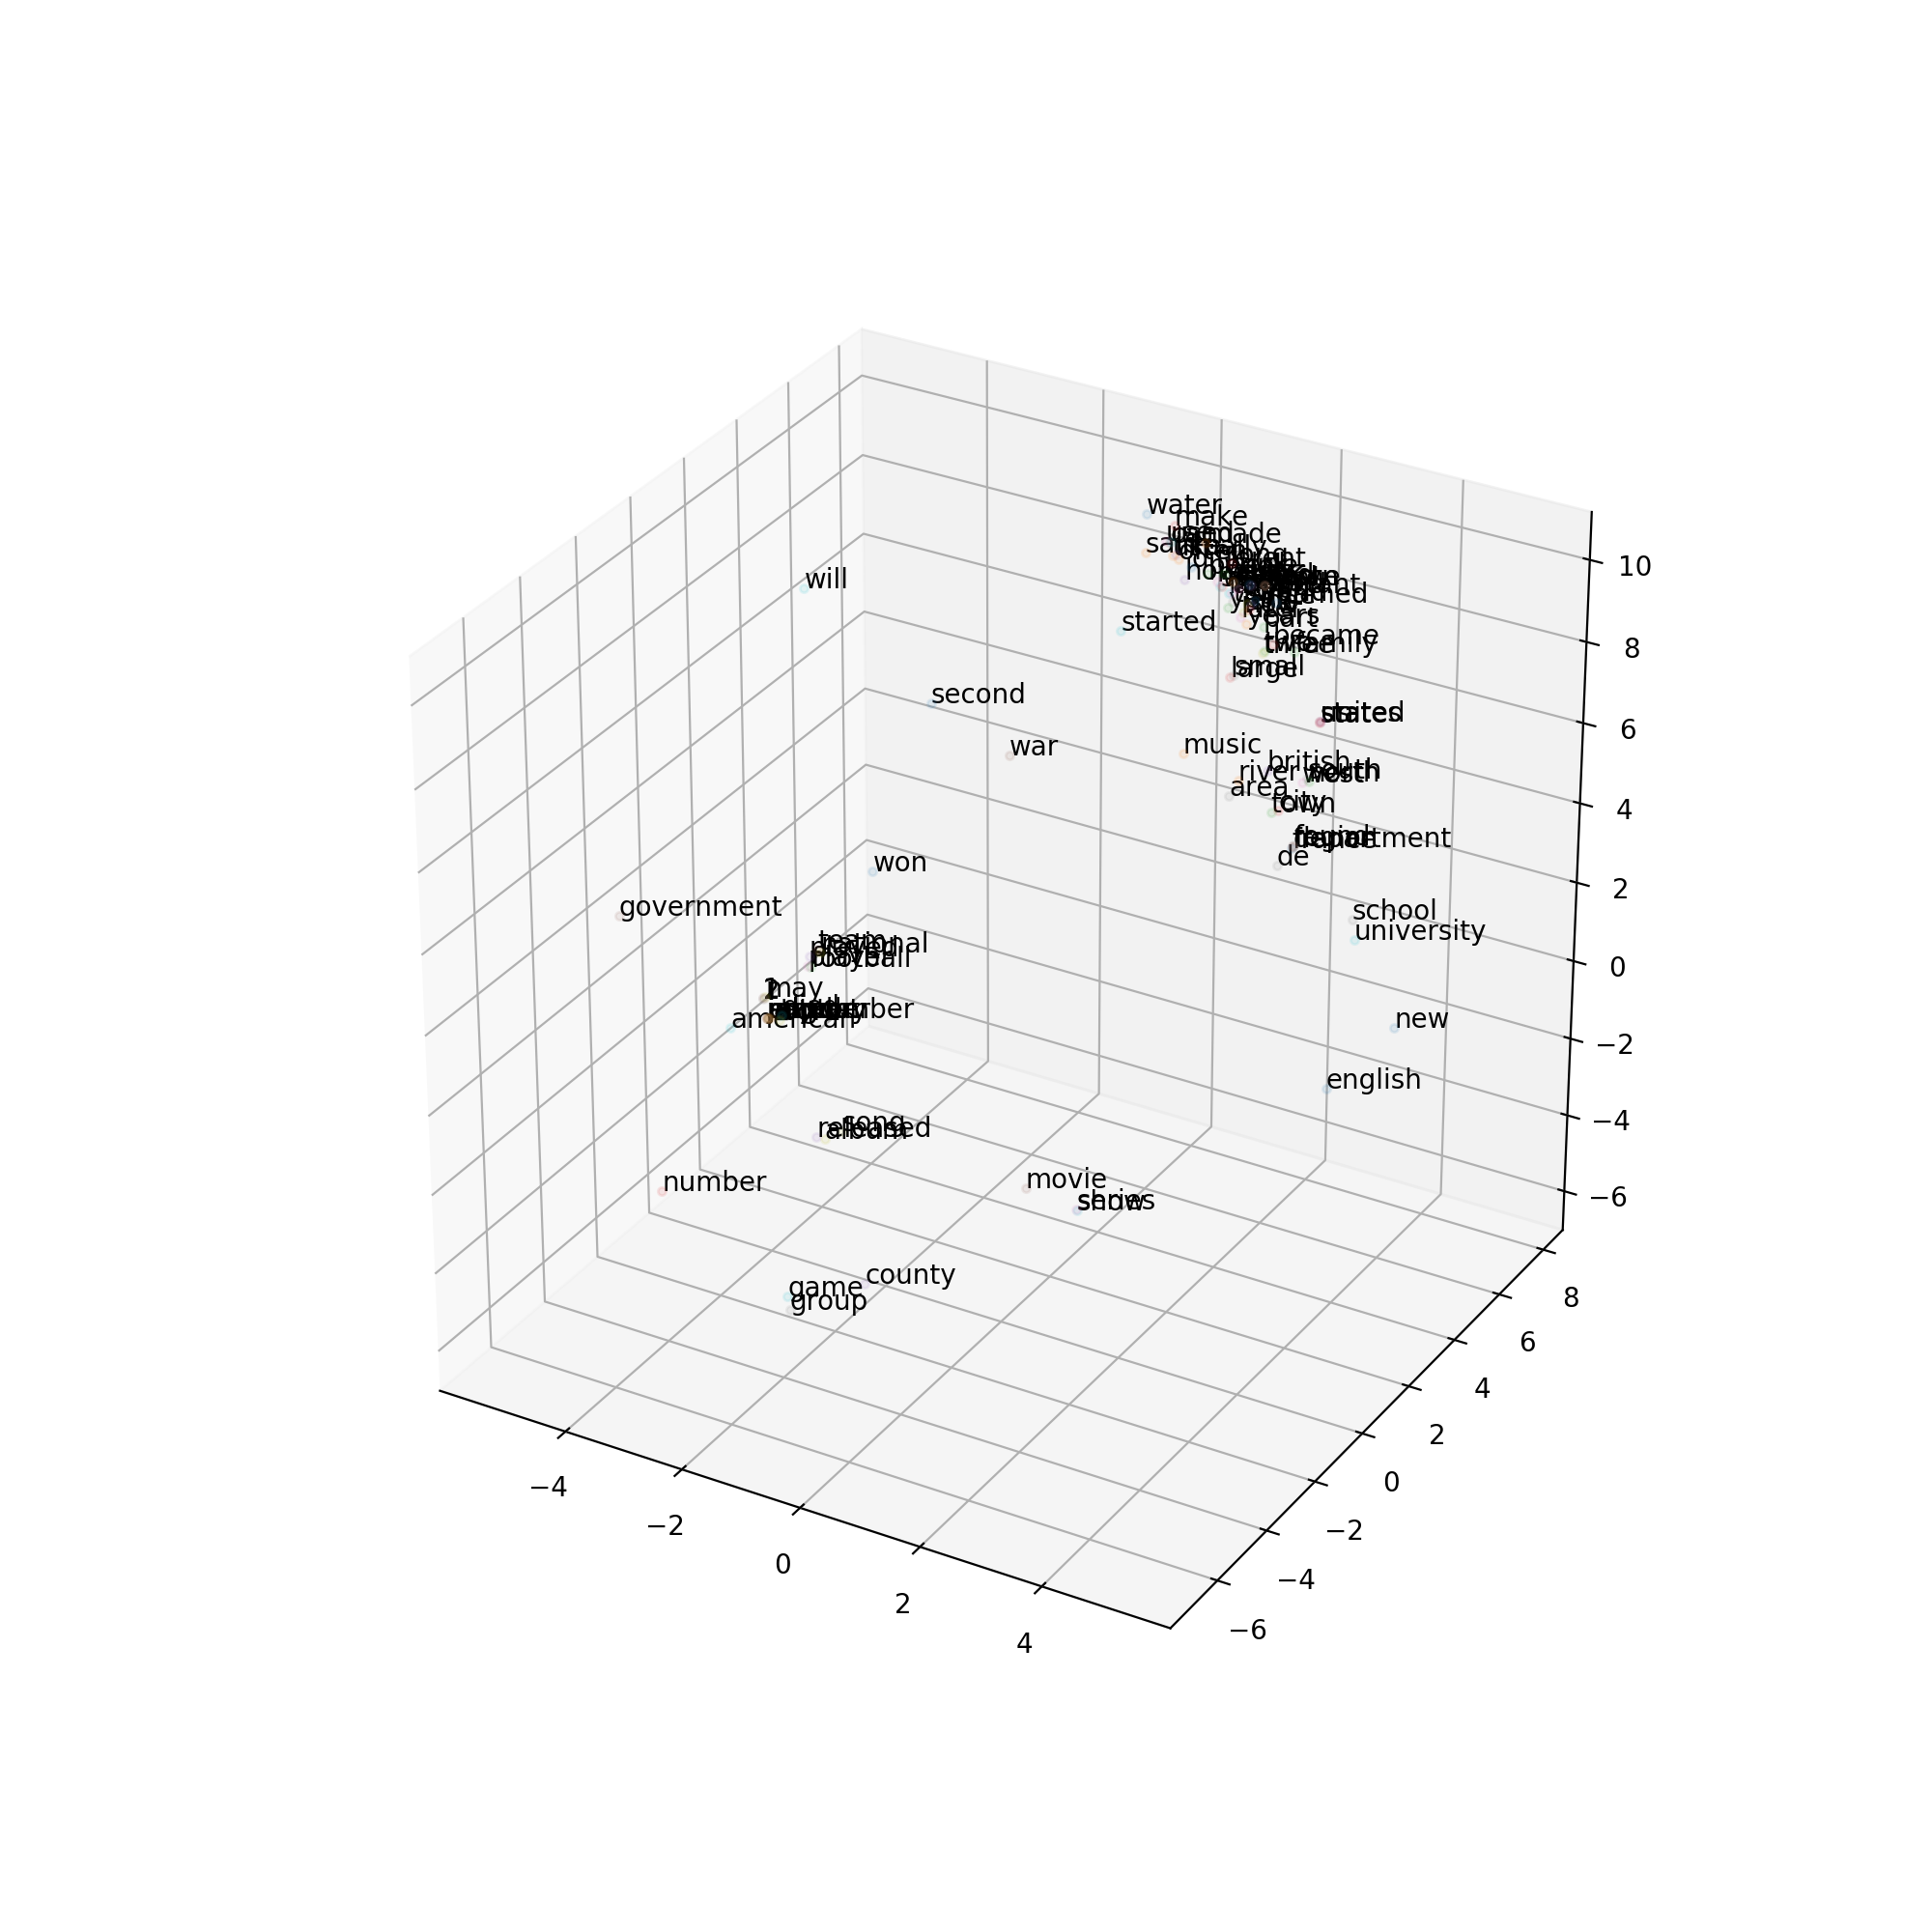

In [48]:
%matplotlib notebook
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection="3d")
for i, (label, _) in enumerate(collections.Counter(wiki.counter).most_common(100)):
    x, y, z = post_tsne_glove.embedding_[i]
    ax.scatter(x, y, z, s=9, alpha=0.1)
    ax.text(x, y, z, label)


Не вполне ясно, что предлагается из этого выжимать, впрочем. Давайте просто померяем углы:

In [40]:
def get_angle(wiki, pairs):
    return np.arccos(cosine_similarity(
        [sum(post_tsne_glove.embedding_[wiki.vocab[x]]*sign for x, sign in zip(pairs[0], (1, -1)))],
        [sum(post_tsne_glove.embedding_[wiki.vocab[x]]*sign for x, sign in zip(pairs[1], (1, -1)))]
    ))[0][0]*90/np.pi

In [41]:
get_angle(wiki, [("man", "woman"), ("mr", "ms")])

23.879964812352448

Более-менее

In [42]:
get_angle(wiki, [("good", "best"), ("bad", "worst")])

19.797370467690026

Тоже неплохо, в принципе.

Метрика для сравнения моделей --- количество правильных ответов на вопросы из датасета Миколова:

In [43]:
with open("questions-words.txt") as question_file:
    parsed = (
        line for line in (
            tuple(wiki._normalize(line)) for line in question_file.readlines() if not line.startswith(":")
        ) if len(line) == 4
    )

    *questions, labels = zip(*parsed)

    questions = list(zip(*questions))

In [44]:
def evaluate(embeds, wiki, questions, labels):
    total = 0
    for i, (label, (pos1, neg, pos2)) in enumerate(zip(labels, questions)):
        if i % 50 == 0:
            print("{}\r".format((i, total)), end="")
        total += (label in set(x[1] for x in get_analogy([pos1, pos2], [neg], embeds, wiki)))
    return total

In [47]:
evaluate(lsa_embeds, wiki, questions, labels)

1527

In [46]:
evaluate(w2v_embeds, wiki, questions, labels)

2646

In [45]:
evaluate(glove_embeds, wiki, questions, labels)

1160

Ну. Могло быть лучше, конечно, но w2v всех обошёл в ~2 раза